In [1]:
import pandas as pd
import numpy as np
import scipy 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from random import choices,sample

import os
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

from datetime import timedelta
from tqdm import tqdm

plt.style.use('ggplot')

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"

os.chdir("../../")
root_path = os.getcwd()

raw_file_path = os.path.join(root_path, "Bigcon2020_raw_file")
csv_file_path = os.path.join(root_path, "BigCon_2020/csv_files")
pickle_file_path = os.path.join(root_path, "BigCon_2020/pickle_files")

raw_file_folders = os.listdir(raw_file_path)

folder_path = os.path.join(raw_file_path, raw_file_folders[0])

In [331]:
def register_add_time_property(register):
    register['STD_DD']=pd.to_datetime(register.STD_DD, format='%Y%m%d')
    
    register['year'] = register['STD_DD'].dt.year.values
    register['month'] = register['STD_DD'].dt.month.values
    register['weekofyear'] = register['STD_DD'].dt.weekofyear.values
    register['dayofweek'] = register['STD_DD'].dt.dayofweek.values

    register['weekday'] = np.where(register.dayofweek<5,'평일','주말')
    
    return register

In [346]:
register.head(2)

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,GU_NM,HDONG_NM,year,month,weekofyear,dayofweek,weekday,MCT_CAT_NM
0,2019-02-01,110,517,10,F,25,11,595,대구 중구,동인동,2019,2,5,4,평일,숙박
1,2019-02-01,110,517,10,F,50,5,243,대구 중구,동인동,2019,2,5,4,평일,숙박


In [359]:
def convert_code_to_name_register(register):
    df = register
    df['region_code'] = df.GU_CD.astype(str)+df.DONG_CD.astype(str)
    
    with open(os.path.join(pickle_file_path, 'card_code_to_name_dict.pickle'), 'rb') as f:
        card_code_to_name_dict = pickle.load(f)
        
    cat_dict = {10 : '숙박',
                20 : '레저용품',
                21 : '레저업소',
                22 : '문화취미',
                30 : '가구',
                31 : '전기',
                32 : '주방용구',
                33 : '연료판매',
                34 : '광학제품',
                35 : '가전',
                40 : '유통업',
                42 : '의복',
                43 : '직물',
                44 : '신변잡화',
                50 : '서적문구',
                52 : '사무통신',
                60 : '자동차판매',
                62 : '자동차 정비',
                70 : '의료기관',
                71 : '보건위생',
                80 : '요식업소',
                81 : '음료식품',
                92 : '수리서비스'}
    
    df['GU_NM'] = df.region_code.map(card_code_to_name_dict.get('구명'))
    df['HDONG_NM'] = df.region_code.map(card_code_to_name_dict.get('행정동명'))
    df['MCT_CAT_NM'] = df.MCT_CAT_CD.map(cat_dict)
    
    return df

In [355]:
sk_files = [file for file in os.listdir(csv_file_path) if file.startswith('SK_melted')]
card_files = [file for file in os.listdir(csv_file_path) if file.startswith('카드')]

In [356]:
df_list_card = []

for file_name in card_files:
    file_path = os.path.join(csv_file_path, file_name)
    df = pd.read_csv(file_path)
    df_list_card.append(df)

In [357]:
df_list_sk = []

for file_name in sk_files:
    file_path = os.path.join(csv_file_path, file_name)
    df = pd.read_csv(file_path)
    df_list_sk.append(df)

In [360]:
register = df_list_card[1].drop(df_list_card[1].columns[0], axis=1)

register = convert_code_to_name_register(register)
register = register_add_time_property(register)

register.head()

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,region_code,GU_NM,HDONG_NM,MCT_CAT_NM,year,month,weekofyear,dayofweek,weekday
0,2019-02-01,110,517,10,F,25,11,595,110517,대구 중구,동인동,숙박,2019,2,5,4,평일
1,2019-02-01,110,517,10,F,50,5,243,110517,대구 중구,동인동,숙박,2019,2,5,4,평일
2,2019-02-01,110,517,10,F,55,5,27,110517,대구 중구,동인동,숙박,2019,2,5,4,평일
3,2019-02-01,110,517,10,M,20,11,243,110517,대구 중구,동인동,숙박,2019,2,5,4,평일
4,2019-02-01,110,517,10,M,25,11,433,110517,대구 중구,동인동,숙박,2019,2,5,4,평일


In [13]:
fp_age= df_list_sk[0]
fp_time = df_list_sk[1]

* RISK INDEX
    * 코로나기간 (3월최저점 ~ +7일) - (2월최고점 ~ +7일)  
    => 기간 1주일로 잡은이유 
        : 카드소비 및 유통(GS편의점)소비에서 모두 일주일마다 소비의 패턴이 유사함을 볼 수 있었음. 따라서 1주일을 기간의 unit으로 설정하였고 기간이 길어질수록, 코로나 상황이 가장심했던 기간이후 소비가 회복되는 시점을 포함하는 경우가 많아져 1주일을 기준으로 잡게 됨
    * 비교구간 (2019년 2월,3월)
    => 기간 1달 : 평상시 상황을 최대한 고려하기 위해 기간을 좀 더 넓게 잡음
    
        * 유동인구
        * 카드소비액
            * 불규칙하게 소비액이 급등하는 날이 있었고, 이에 대한 타당한 이유를 찾지 못해 각 기간동안 하위5%, 상위5% 소비액을 제외한후 평균소비액을 구함. 평균소비액을 사용한 이유는 2월과 3월의 일수가 달라 합으로 계산했을시 왜곡된 결과가 나올수 있다고 생각했기 때문         
        * 카드소비횟수
            * 카드소비액과 동일한 방식

In [68]:
def get_minNmax_fp_date(df):
    
    #설연휴 유동인구의 경우 특별한 케이스이므로 제외    
    df_feb_2019 = df.query('year==2019 & month==2 & STD_YMD not in[\'2019-02-01\',\'2019-02-02\',\'2019-02-03\',\'2019-02-04\',\'2019-02-05\',\'2019-02-06\']')
    df_mar_2019 = df.query('year==2019 & month==3')
    
    df_feb_2020 = df.query('year==2020 & month==2')
    df_mar_2020 = df.query('year==2020 & month==3')
    
    mx2019 = np.argmax(df_feb_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    mn2019 = np.argmin(df_mar_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    
    mx2020 = np.argmax(df_feb_2020.groupby(['STD_YMD'])['flow_counts'].sum())
    mn2020 = np.argmin(df_mar_2020.groupby(['STD_YMD'])['flow_counts'].sum())
    
    return mn2019,mx2019,mn2020,mx2020

In [333]:
def risk_index_fp(df):
    hdong = list(df.HDONG_NM.unique())
    risk_by_dong = {}
    
    for dong in tqdm(hdong):
        tmp_df = df.loc[df.HDONG_NM==dong]
        min2019,max2019,min2020,max2020 = get_minNmax_fp_date(tmp_df)
        
        tmp_df = tmp_df.groupby('STD_YMD')['flow_counts'].sum().reset_index()
        
        # min_date_index_2019 = tmp_df[tmp_df.STD_YMD == min2019].index.values[0]
        # max_date_index_2019 = tmp_df[tmp_df.STD_YMD == max2019].index.values[0]
        
        min_date_index_2020 = tmp_df[tmp_df.STD_YMD == min2020].index.values[0]
        max_date_index_2020 = tmp_df[tmp_df.STD_YMD == max2020].index.values[0]
        
        # fp_feb_2019 = tmp_df.iloc[min_date_index_2019:min_date_index_2019+7,1].sum()
        # fp_mar_2019 = tmp_df.iloc[max_date_index_2019:max_date_index_2019+7,1].sum()
        
        fp_feb_2019 = tmp_df.iloc[:28,1].mean()
        fp_mar_2019 = tmp_df.iloc[28:28+31,1].mean()
        
        fp_feb_2020 = tmp_df.iloc[min_date_index_2020:min_date_index_2020+7,1].sum()
        fp_mar_2020 = tmp_df.iloc[max_date_index_2020:max_date_index_2020+7,1].sum()
        
        r1 = (fp_mar_2019 - fp_feb_2019)/fp_feb_2019
        r2 = (fp_mar_2020 - fp_feb_2020)/fp_feb_2020
        
        risk = np.sqrt((r1+1)*(r2+1))-1
        
        risk_by_dong[dong] = risk
        
    return risk_by_dong

In [334]:
risk_fp = risk_index_fp(fp_time)
risk_fp

100%|███████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 28.18it/s]


{'고산1동': 0.16434175780614302,
 '고산2동': 0.14683700127673216,
 '고산3동': 0.12188458055948792,
 '공릉1동': 0.11580190981322058,
 '공릉2동': 0.161186476099745,
 '광희동': 0.22643143625665796,
 '남산1동': 0.2480224307585377,
 '남산2동': 0.35023624640543605,
 '남산3동': 0.17448727350555737,
 '남산4동': 0.10010788911926283,
 '다산동': 0.21509276750020767,
 '대봉1동': 0.14303057324373913,
 '대봉2동': 0.22114842277266433,
 '대신동': 0.30583784905608136,
 '동인동': 0.24795224564474205,
 '동화동': 0.42128369224935125,
 '두산동': 0.1394192784922983,
 '만촌1동': 0.18314637381369514,
 '만촌2동': 0.2814392636565004,
 '만촌3동': 0.1493902699675418,
 '명동': 0.2463117226525937,
 '범물1동': 0.13586474396814907,
 '범물2동': 0.09829860687624659,
 '범어1동': 0.18770667476399594,
 '범어2동': 0.28240535550614254,
 '범어3동': 0.2415832516281764,
 '범어4동': 0.4390105149218524,
 '삼덕동': 0.312531212022078,
 '상계10동': 0.10026788710594903,
 '상계1동': 0.12097645754258601,
 '상계2동': 0.18588715398880407,
 '상계3.4동': 0.03713464318237758,
 '상계5동': 0.07114612993583713,
 '상계6.7동': 0.10612803842133

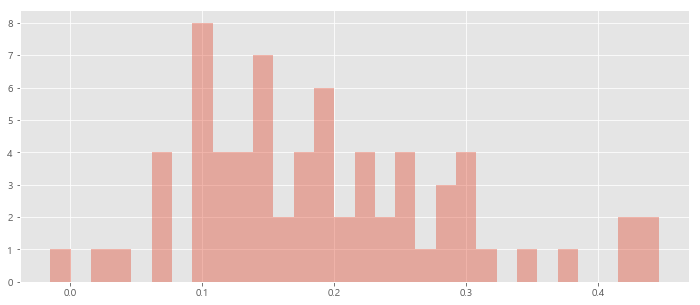

In [158]:
plt.figure(figsize=(12,5))
sns.distplot([v for i,v in risk_fp.items()], kde=False, bins=30)

In [362]:
def get_minNmax_cardAMT_date(df):
    
    # 설연휴 유동인구의 경우 특별한 케이스이므로 제외    
    # df_feb_2019 = df.query('year==2019 & month==2 & STD_DD not in[\'2019-02-01\',\'2019-02-02\',\'2019-02-03\',\'2019-02-04\',\'2019-02-05\',\'2019-02-06\']')
    # df_mar_2019 = df.query('year==2019 & month==3')
    
    df_feb_2020 = df.query('year==2020 & month==2')
    df_mar_2020 = df.query('year==2020 & month==3')
    
    # mx2019 = np.argmax(df_feb_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    # mn2019 = np.argmin(df_mar_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    
    mx2020 = np.argmax(df_feb_2020.groupby(['STD_DD'])['USE_AMT'].sum())
    mn2020 = np.argmin(df_mar_2020.groupby(['STD_DD'])['USE_AMT'].sum())
    
    return mn2020,mx2020

In [363]:
# outlier제거하는 방향으로 해봐야할듯

def risk_index_cardAMT(df):
    hdong = list(df.HDONG_NM.unique())
    risk_by_dong = {}
    
    for dong in tqdm(hdong):
        tmp_df = df.loc[df.HDONG_NM==dong]
        min2020,max2020 = get_minNmax_cardAMT_date(tmp_df)
        
        tmp_df = tmp_df.groupby(['STD_DD','year','month'])['USE_AMT'].sum().reset_index()
        
        min_date_index_2020 = tmp_df[tmp_df.STD_DD == min2020].index.values[0]
        max_date_index_2020 = tmp_df[tmp_df.STD_DD == max2020].index.values[0]
        
        # 2월과 3월의 날짜가 차이가 나기때문에 평균소비액으로 계산
        # 가끔 불규칙한 주기로 매출액이 유독 높아지는 날이 있음. 이에 대한 근거가 생기기 전까지는 이상치로 판단하여
        # 제거하는 방향으로 진행.
        
        # 하위 5%와 상위5% 소비금액 제거후 평균계산
        # 5%기준으로 한 이유 : 월별로 값을 보기때문에 데이터의 크기가 31을 넘지 않음. 가장 큰 날 하루를 뺀다고 했을때 이미 3%가 넘으므로 5%를 기준으로 하게 됨
        feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum().quantile([.05,.95]).astype(int).tolist()
        mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum().quantile([.05,.95]).astype(int).tolist()
        
        # mean_cardAMT_feb_2019 = tmp_df.iloc[:28,1].mean() # 19.02.01 ~ 19.02.28까지 매출의 평균
        # mean_cardAMT_mar_2019 = tmp_df.iloc[28:28+31,1].mean() # 19.03.01 ~ 19.03.31까지 매출의 평균
        
        mean_cardAMT_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum() \
                             if val in range(*feb_2019_filter)])
        mean_cardAMT_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum() \
                                 if val in range(*mar_2019_filter)]) 
        
        cardAMT_feb_2020 = tmp_df.iloc[min_date_index_2020:min_date_index_2020+7,-1].sum()
        cardAMT_mar_2020 = tmp_df.iloc[max_date_index_2020:max_date_index_2020+7,-1].sum()
        
        r1 = (mean_cardAMT_mar_2019 - mean_cardAMT_feb_2019)/mean_cardAMT_feb_2019
        r2 = (cardAMT_mar_2020 - cardAMT_feb_2020)/cardAMT_feb_2020
        
        risk = np.sqrt((r1+1)*(r2+1))-1
        
        risk_by_dong[dong] = risk
        
    return risk_by_dong

In [406]:
def plot_cardAMT_risk(df, dong):
    tmp_df = df.loc[df.HDONG_NM==dong].reset_index(drop=True)
    
    tmp_df['STD_DD'] = tmp_df.STD_DD.astype(str)
    
    feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum().quantile([.05,.95]).astype(int).tolist()
    mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum().quantile([.05,.95]).astype(int).tolist()
    
    # mean_feb_2019 = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum().mean()
    # mean_mar_2019 = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum().mean()
    
    mean_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum() \
                         if val in range(*feb_2019_filter)])
    mean_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum() \
                            if val in range(*mar_2019_filter)])
    
    max_feb_2020 = np.max(tmp_df.query('year==2020 & month==2').groupby('STD_DD')['USE_AMT'].sum())

    fig, ax = plt.subplots(figsize=(16,9))
    ax = sns.lineplot(
        data = tmp_df.groupby('STD_DD')['USE_AMT'].sum().reset_index(),
        x = 'STD_DD',
        y = 'USE_AMT',
        color = 'k',
        linewidth=0.8
    )
    
    low, high = ax.get_ybound()
    
    # ax.vlines(x=120.5, ymin=low*0.9, ymax=high*1.1, color='blue', linewidth=0.8)
    
    ax.hlines(y=mean_feb_2019, xmin=-0.5, xmax=28.5, color = 'blue')
    ax.hlines(y=mean_mar_2019, xmin=28.5, xmax=59.5, color = 'blue')
    
    if mean_mar_2019 - mean_feb_2019 > 0:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 증가', (24, mean_mar_2019*1.05), color='red', fontsize=16)
    else:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 감소', (24, mean_feb_2019*0.8), color='blue', fontsize=16)
    
    ax.annotate(s='2019년', xy=(5,high*0.95), fontsize=20)
    ax.annotate(s='2020년', xy=(125,high*0.95), fontsize=20)
    ax.annotate(s='', xy=(28.5,mean_feb_2019), xytext=(28.5,mean_mar_2019), arrowprops=dict(arrowstyle='<->', color='blue'))
    ax.axvspan(xmin=120, xmax=241, color='skyblue', alpha=0.1)

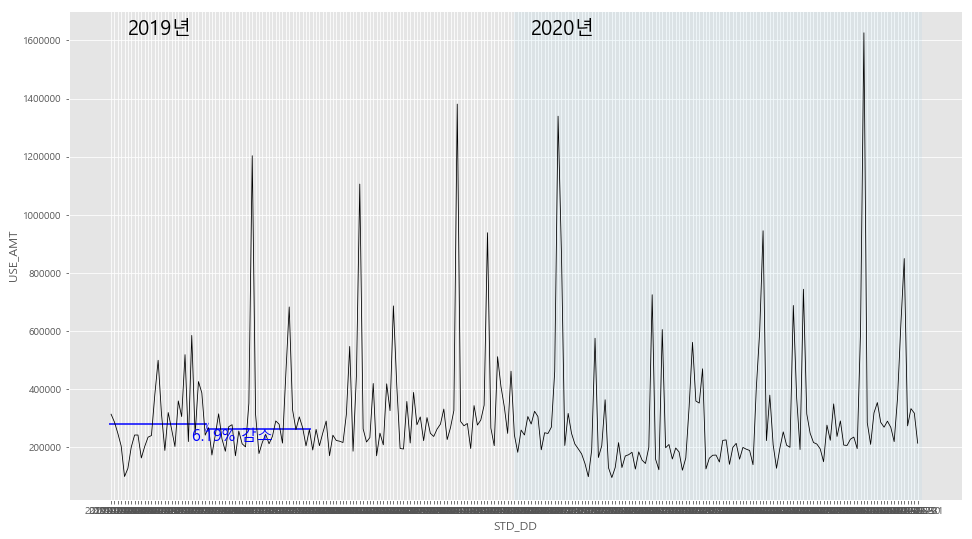

In [421]:
plot_cardAMT_risk(register, '황금2동')

In [392]:
# risk_index_cardAMT(register)

100%|███████████████████████████████████████████████████████████████████| 69/69 [00:11<00:00,  6.23it/s]


{'고산1동': 0.25605286181069786,
 '고산2동': 0.1634233536181371,
 '고산3동': 0.08454685240547821,
 '공릉1동': 0.06373740307522113,
 '공릉2동': 0.1722143018329092,
 '광희동': 0.18971472648479404,
 '남산1동': 0.2524531579599303,
 '남산2동': 0.5827420549240403,
 '남산3동': 0.5335397569433866,
 '남산4동': 0.02782308012123247,
 '다산동': 0.03003283497807585,
 '대봉1동': 0.47536611122961636,
 '대봉2동': 0.8295327738148255,
 '대신동': 0.678052844612415,
 '동인동': 0.4112888381449151,
 '동화동': 0.09388659349167283,
 '두산동': 0.24996758047845713,
 '만촌1동': 0.2431832552371347,
 '만촌2동': 0.6384708411754116,
 '만촌3동': 0.22463271785293903,
 '명동': 0.15842257931861958,
 '범물1동': 0.2831872082365501,
 '범물2동': 0.03487457776307479,
 '범어1동': 0.35235043193936955,
 '범어2동': 0.5325614184311267,
 '범어3동': 0.31740885787586093,
 '범어4동': 0.23003390137004853,
 '삼덕동': 0.42274622049771415,
 '상계10동': 0.11634341619719013,
 '상계1동': 0.048202904097483845,
 '상계2동': 0.15676439622610205,
 '상계3.4동': 0.04240825942335191,
 '상계5동': -0.014008578754701961,
 '상계6.7동': 0.1472086431141

215

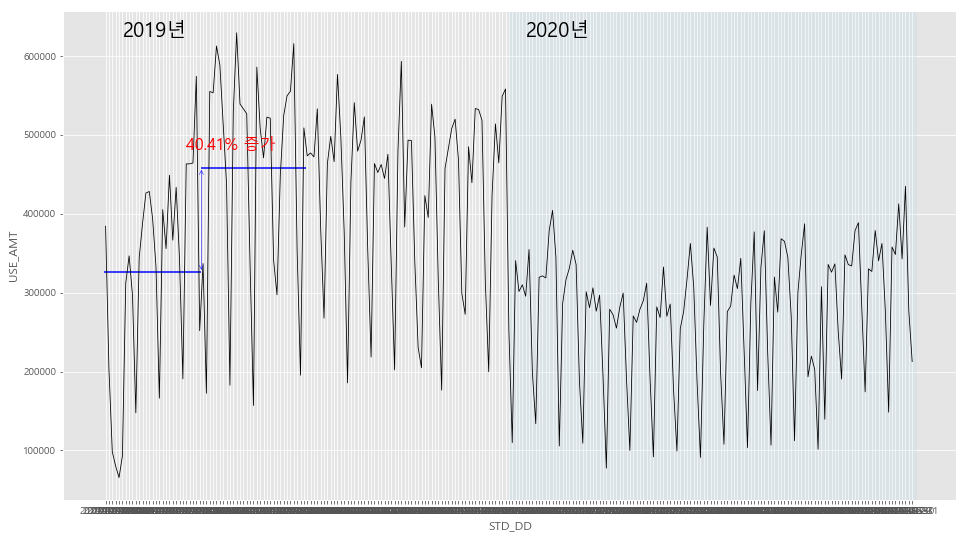

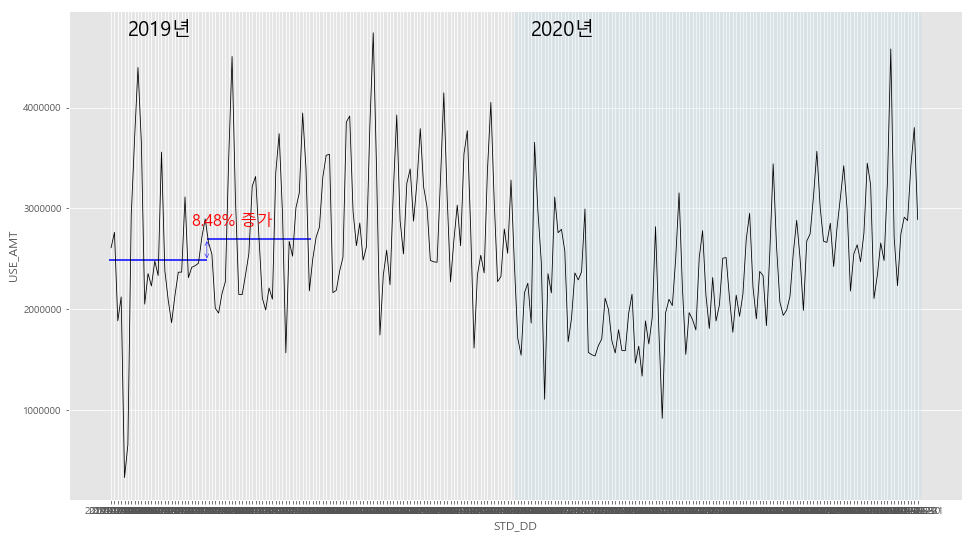

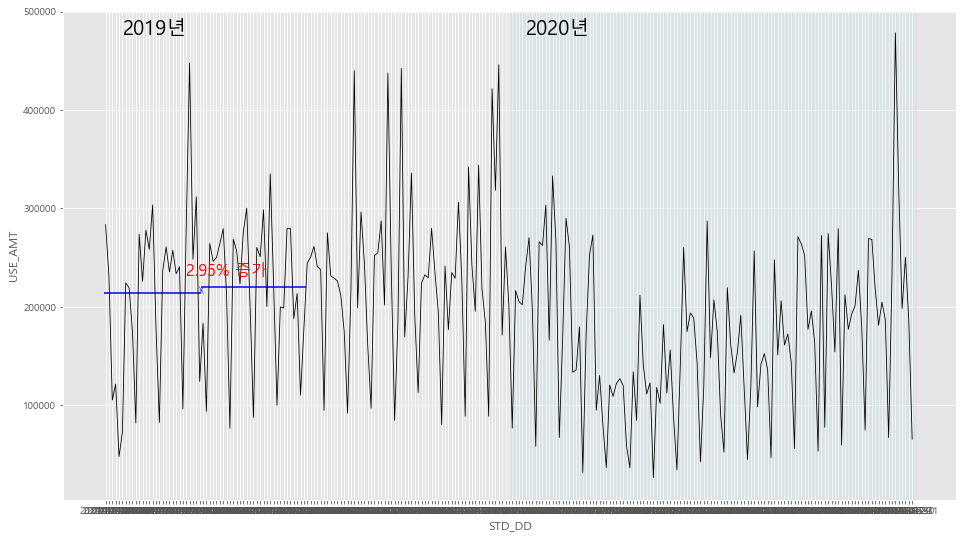

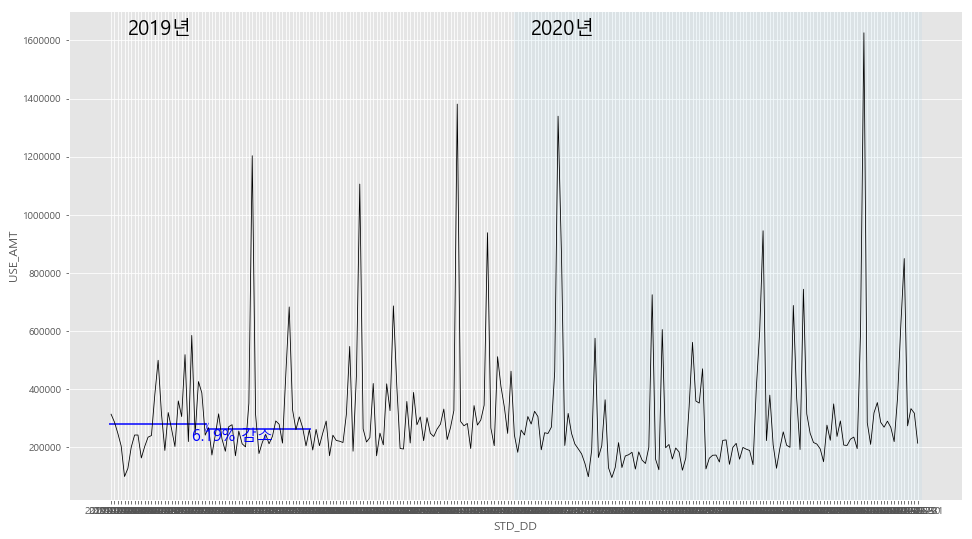

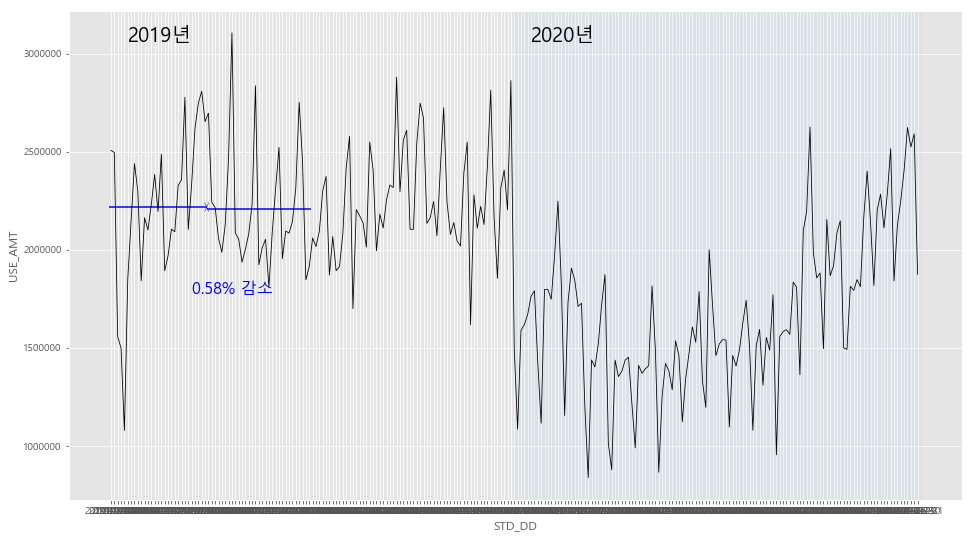

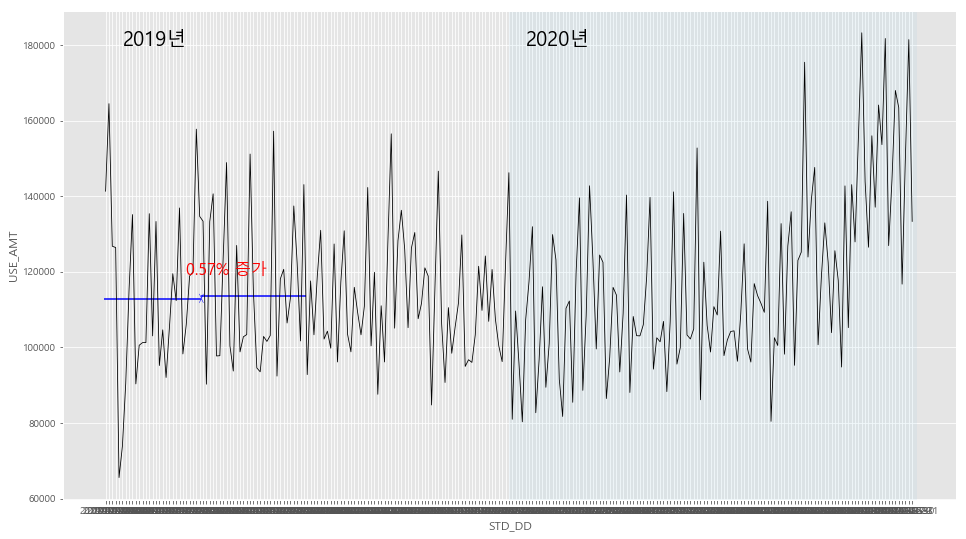

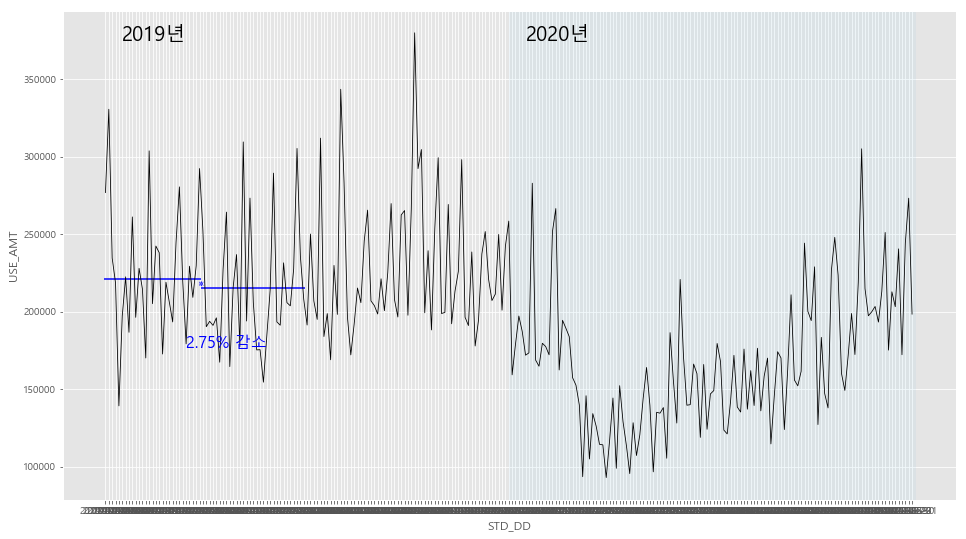

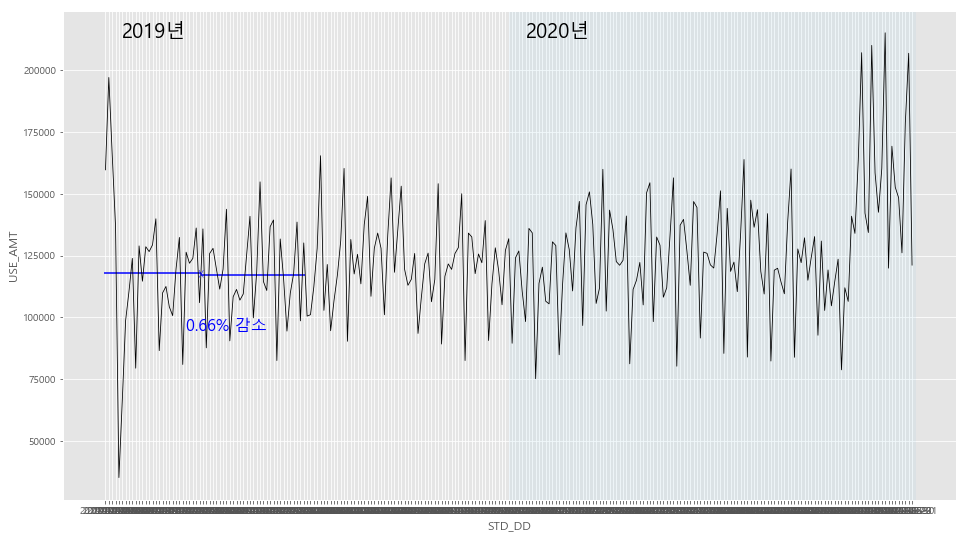

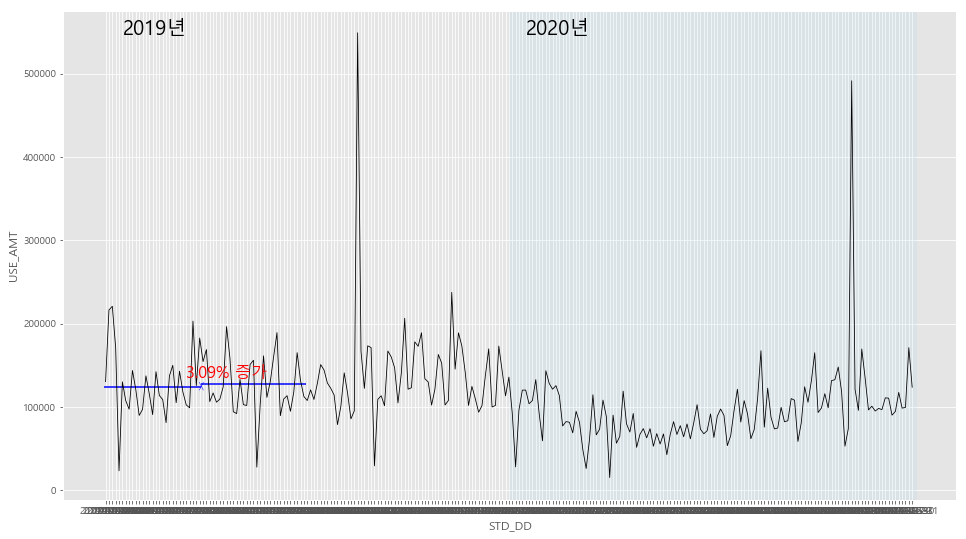

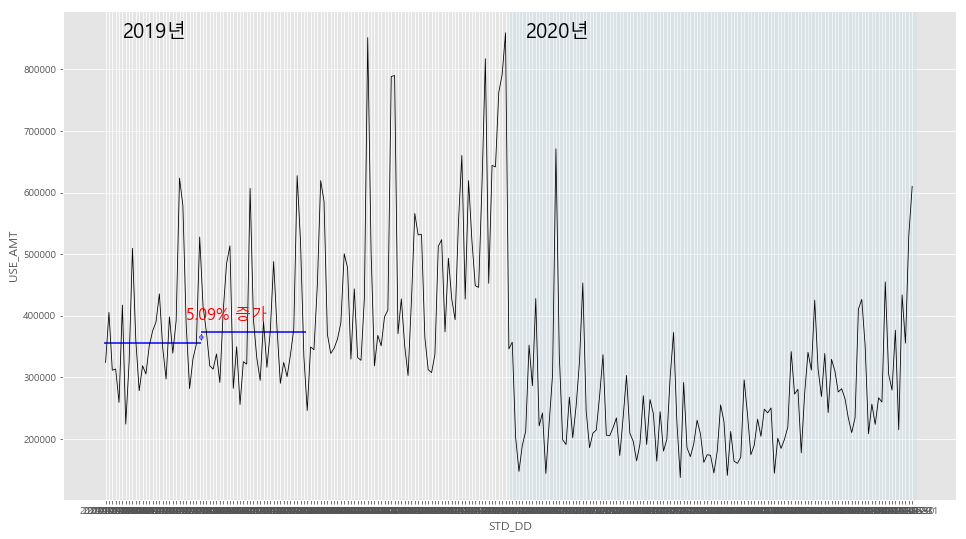

In [407]:
for dong in choices(register.HDONG_NM.unique().tolist(),k=10):
    plot_cardAMT_risk(register, dong)
    
gc.collect()

In [408]:
def get_minNmax_cardCNT_date(df):
    
    # 설연휴 유동인구의 경우 특별한 케이스이므로 제외    
    # df_feb_2019 = df.query('year==2019 & month==2 & STD_DD not in[\'2019-02-01\',\'2019-02-02\',\'2019-02-03\',\'2019-02-04\',\'2019-02-05\',\'2019-02-06\']')
    # df_mar_2019 = df.query('year==2019 & month==3')
    
    df_feb_2020 = df.query('year==2020 & month==2')
    df_mar_2020 = df.query('year==2020 & month==3')
    
    # mx2019 = np.argmax(df_feb_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    # mn2019 = np.argmin(df_mar_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    
    mx2020 = np.argmax(df_feb_2020.groupby(['STD_DD'])['USE_CNT'].sum())
    mn2020 = np.argmin(df_mar_2020.groupby(['STD_DD'])['USE_CNT'].sum())
    
    return mn2020,mx2020

In [409]:
# outlier제거하는 방향으로 해봐야할듯

def risk_index_cardCNT(df):
    hdong = list(df.HDONG_NM.unique())
    risk_by_dong = {}
    
    for dong in tqdm(hdong):
        tmp_df = df.loc[df.HDONG_NM==dong]
        min2020,max2020 = get_minNmax_cardCNT_date(tmp_df)
        
        tmp_df = tmp_df.groupby(['STD_DD','year','month'])['USE_CNT'].sum().reset_index()
        
        min_date_index_2020 = tmp_df[tmp_df.STD_DD == min2020].index.values[0]
        max_date_index_2020 = tmp_df[tmp_df.STD_DD == max2020].index.values[0]
        
        # 2월과 3월의 날짜가 차이가 나기때문에 평균소비액으로 계산
        # 가끔 불규칙한 주기로 매출액이 유독 높아지는 날이 있음. 이에 대한 근거가 생기기 전까지는 이상치로 판단하여
        # 제거하는 방향으로 진행.
        
        # 하위 5%와 상위5% 소비금액 제거후 평균계산
        # 5%기준으로 한 이유 : 월별로 값을 보기때문에 데이터의 크기가 31을 넘지 않음. 가장 큰 날 하루를 뺀다고 했을때 이미 3%가 넘으므로 5%를 기준으로 하게 됨
        feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
        mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
        
        # mean_cardCNT_feb_2019 = tmp_df.iloc[:28,1].mean() # 19.02.01 ~ 19.02.28까지 매출의 평균
        # mean_cardCNT_mar_2019 = tmp_df.iloc[28:28+31,1].mean() # 19.03.01 ~ 19.03.31까지 매출의 평균
        
        mean_cardCNT_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum() \
                             if val in range(*feb_2019_filter)])
        mean_cardCNT_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum() \
                                 if val in range(*mar_2019_filter)]) 
        
        cardCNT_feb_2020 = tmp_df.iloc[min_date_index_2020:min_date_index_2020+7,-1].sum()
        cardCNT_mar_2020 = tmp_df.iloc[max_date_index_2020:max_date_index_2020+7,-1].sum()
        
        r1 = (mean_cardCNT_mar_2019 - mean_cardCNT_feb_2019)/mean_cardCNT_feb_2019
        r2 = (cardCNT_mar_2020 - cardCNT_feb_2020)/cardCNT_feb_2020
        
        risk = np.sqrt((r1+1)*(r2+1))-1
        
        risk_by_dong[dong] = risk
        
    return risk_by_dong

In [411]:
def plot_cardCNT_risk(df, dong):
    tmp_df = df.loc[df.HDONG_NM==dong].reset_index(drop=True)
    
    tmp_df['STD_DD'] = tmp_df.STD_DD.astype(str)
    
    feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
    mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
    
    # mean_feb_2019 = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum().mean()
    # mean_mar_2019 = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum().mean()
    
    mean_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum() \
                         if val in range(*feb_2019_filter)])
    mean_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum() \
                            if val in range(*mar_2019_filter)])
    
    max_feb_2020 = np.max(tmp_df.query('year==2020 & month==2').groupby('STD_DD')['USE_CNT'].sum())

    fig, ax = plt.subplots(figsize=(16,9))
    ax = sns.lineplot(
        data = tmp_df.groupby('STD_DD')['USE_CNT'].sum().reset_index(),
        x = 'STD_DD',
        y = 'USE_CNT',
        color = 'k',
        linewidth=0.8
    )
    
    low, high = ax.get_ybound()
    
    # ax.vlines(x=120.5, ymin=low*0.9, ymax=high*1.1, color='blue', linewidth=0.8)
    
    ax.hlines(y=mean_feb_2019, xmin=-0.5, xmax=28.5, color = 'blue')
    ax.hlines(y=mean_mar_2019, xmin=28.5, xmax=59.5, color = 'blue')
    
    if mean_mar_2019 - mean_feb_2019 > 0:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 증가', (24, mean_mar_2019*1.05), color='red', fontsize=16)
    else:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 감소', (24, mean_feb_2019*0.8), color='blue', fontsize=16)
    
    ax.annotate(s='2019년', xy=(5,high*0.95), fontsize=20)
    ax.annotate(s='2020년', xy=(125,high*0.95), fontsize=20)
    ax.annotate(s='', xy=(28.5,mean_feb_2019), xytext=(28.5,mean_mar_2019), arrowprops=dict(arrowstyle='<->', color='blue'))
    ax.axvspan(xmin=120, xmax=241, color='skyblue', alpha=0.1)

In [410]:
risk_index_cardCNT(register)

100%|███████████████████████████████████████████████████████████████████| 69/69 [00:10<00:00,  6.28it/s]


{'고산1동': 0.2033954954589754,
 '고산2동': 0.1954715550894779,
 '고산3동': 0.10633639488592483,
 '공릉1동': 0.05647622559513277,
 '공릉2동': 0.20671251603392027,
 '광희동': 0.19173299736874538,
 '남산1동': 0.2938679811432503,
 '남산2동': 0.46122292629414186,
 '남산3동': 0.17810353900649734,
 '남산4동': 0.12776061453400933,
 '다산동': 0.039394052004677826,
 '대봉1동': 0.3358132234605886,
 '대봉2동': 0.634354832784251,
 '대신동': 0.2705127266628782,
 '동인동': 0.22273963156279564,
 '동화동': 0.052320808558461884,
 '두산동': 0.24231516645963835,
 '만촌1동': 0.19390368635566713,
 '만촌2동': 0.33394262520469953,
 '만촌3동': 0.2148265294099112,
 '명동': 0.20613477699695326,
 '범물1동': 0.30700494817065827,
 '범물2동': -0.0004790792053641635,
 '범어1동': 0.2329296257627178,
 '범어2동': 0.5352494433029855,
 '범어3동': 0.20704837860018466,
 '범어4동': 0.2883724747031484,
 '삼덕동': 0.5542399715226285,
 '상계10동': 0.13138691518797985,
 '상계1동': 0.017520888012223734,
 '상계2동': 0.11963257003337402,
 '상계3.4동': 0.008754099077922683,
 '상계5동': -0.03303217304744044,
 '상계6.7동': 0.1290789

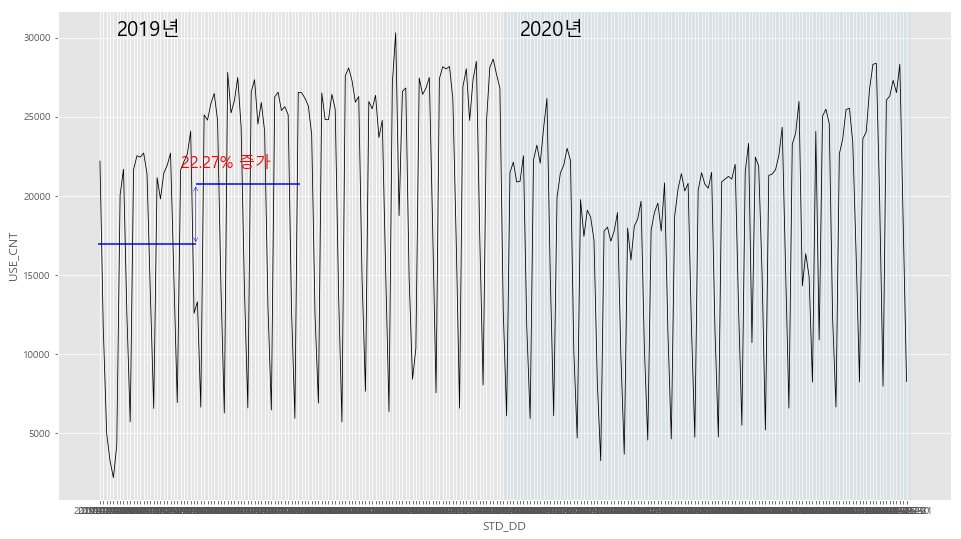

In [413]:
plot_cardCNT_risk(register, '을지로동')

In [416]:
risk_index_summ = pd.DataFrame(register.HDONG_NM.unique().tolist(), columns=['HDONG_NM'])

In [417]:
ce_fp_time = risk_index_fp(fp_time)
ce_cardAMT = risk_index_cardAMT(register)
ce_cardCNT = risk_index_cardCNT(register)

100%|███████████████████████████████████████████████████████████████████| 69/69 [00:10<00:00,  6.41it/s]


In [418]:
risk_index_summ['ce_fp_time'] = risk_index_summ.HDONG_NM.map(ce_fp_time)
risk_index_summ['ce_cardAMT'] = risk_index_summ.HDONG_NM.map(ce_cardAMT)
risk_index_summ['ce_cardCNT'] = risk_index_summ.HDONG_NM.map(ce_cardCNT)

In [422]:
risk_index_summ

,HDONG_NM,ce_fp_time,ce_cardAMT,ce_cardCNT
0,동인동,0.247952,0.411289,0.222740
1,삼덕동,0.312531,0.422746,0.554240
2,성내1동,0.297617,0.424105,0.683635
3,성내2동,0.371768,0.506350,0.559178
4,성내3동,0.252392,0.751168,0.245786
...,...,...,...,...
64,상계5동,0.071146,-0.014009,-0.033032
65,상계6.7동,0.106128,0.147209,0.129079
66,상계8동,0.030929,0.041419,0.034348
67,상계9동,0.095883,0.007617,-0.016076


In [424]:
with open(os.path.join(pickle_file_path, 'card_code_to_name_dict.pickle'), 'rb') as f:
        card_code_to_name_dict = pickle.load(f)

In [442]:
risk_index_summ['GU_NM'] = risk_index_summ.HDONG_NM.map({v: k for k, v in card_code_to_name_dict.get('행정동명').items()}).map(card_code_to_name_dict.get('구명'))

In [446]:
risk_index_summ['SI_NM'] = risk_index_summ.GU_NM.apply(lambda x : x.split(' ')[0])

In [447]:
risk_index_summ['GU_NM'] = risk_index_summ.GU_NM.apply(lambda x : x.split(' ')[1])

In [450]:
risk_index_summ = risk_index_summ.replace(['대구','서울'], ['대구광역시','서울특별시'])

In [452]:
risk_index_summ.to_csv("risk_index_tableau.csv", index=False)

In [453]:
risk_index_summ

,HDONG_NM,ce_fp_time,ce_cardAMT,ce_cardCNT,GU_NM,SI_NM
0,동인동,0.247952,0.411289,0.222740,중구,대구광역시
1,삼덕동,0.312531,0.422746,0.554240,중구,대구광역시
2,성내1동,0.297617,0.424105,0.683635,중구,대구광역시
3,성내2동,0.371768,0.506350,0.559178,중구,대구광역시
4,성내3동,0.252392,0.751168,0.245786,중구,대구광역시
...,...,...,...,...,...,...
64,상계5동,0.071146,-0.014009,-0.033032,노원구,서울특별시
65,상계6.7동,0.106128,0.147209,0.129079,노원구,서울특별시
66,상계8동,0.030929,0.041419,0.034348,노원구,서울특별시
67,상계9동,0.095883,0.007617,-0.016076,노원구,서울특별시
